In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Dense, Activation

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, metrics
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
h1 = pd.read_csv('Headlines_2021.csv')
h2 = pd.read_csv('Headlines_2020.csv')
h3 = pd.read_csv('Headlines_2019.csv')
h4 = pd.read_csv('Headlines_2018.csv')
h5 = pd.read_csv('Headlines_2017.csv')
h6 = pd.read_csv('Headlines_2016.csv')
stock_price = pd.read_csv('HistoricalData_APPLE.csv')

In [4]:
stock_headlines = pd.concat([h1,h2,h3,h4,h5,h6])
stock_headlines

,Date,Headlines
0,2021-01-01,Tales of underage workers in Apple&quot;s supp...
1,2021-01-02,Why Apple &quot;iCar&quot; Won&quot;t Be Self-...
2,2021-01-03,The best after-Christmas deals you can get rig...
3,2021-01-04,How four of this year&quot;s Transformers help...
4,2021-01-05,The Apple Products That Could Be Released In 2...
...,...,...
361,2016-12-27,Why Apple Inc.&quot;s Next iPad Pro Won&quot;t...
362,2016-12-28,Better Buy: GoPro Inc vs. Garmin Ltd. What Tim...
363,2016-12-29,Family Sues Apple for not using a patented iOS...
364,2016-12-30,Apple: Nikkei Warns of Further Production Cuts...


In [5]:
stock_price.head()

,Date,Close/Last,Volume,Open,High,Low
0,06/09/2021,$127.13,56877940,$127.21,$127.75,$126.52
1,06/08/2021,$126.74,74403770,$126.6,$128.46,$126.2101
2,06/07/2021,$125.9,71057550,$126.17,$126.32,$124.8321
3,06/04/2021,$125.89,75169340,$124.07,$126.16,$123.85
4,06/03/2021,$123.54,76229170,$124.68,$124.85,$123.13


In [6]:
# Removing $ symbol from Close, Open, High and Low columns to convert them to float values
stock_price['Close/Last'] = list(map(lambda x: x[1:], stock_price['Close/Last'].values))
stock_price['Open'] = list(map(lambda x: x[1:], stock_price['Open'].values))
stock_price['High'] = list(map(lambda x: x[1:], stock_price['High'].values))
stock_price['Low'] = list(map(lambda x: x[1:], stock_price['Low'].values))

# Converting the above columns to float dataype
stock_price['Close/Last'] = stock_price['Close/Last'].astype(float)
stock_price['Open'] = stock_price['Open'].astype(float)
stock_price['High'] = stock_price['High'].astype(float)
stock_price['Low'] = stock_price['Low'].astype(float)

In [7]:
stock_price['Date'] = pd.to_datetime(stock_price['Date'])

In [8]:
stock_price.head()

,Date,Close/Last,Volume,Open,High,Low
0,2021-06-09,127.13,56877940,127.21,127.75,126.5200
1,2021-06-08,126.74,74403770,126.60,128.46,126.2101
2,2021-06-07,125.90,71057550,126.17,126.32,124.8321
3,2021-06-04,125.89,75169340,124.07,126.16,123.8500
4,2021-06-03,123.54,76229170,124.68,124.85,123.1300


In [9]:
stock_headlines.head()

,Date,Headlines
0,2021-01-01,Tales of underage workers in Apple&quot;s supp...
1,2021-01-02,Why Apple &quot;iCar&quot; Won&quot;t Be Self-...
2,2021-01-03,The best after-Christmas deals you can get rig...
3,2021-01-04,How four of this year&quot;s Transformers help...
4,2021-01-05,The Apple Products That Could Be Released In 2...


In [10]:
stock_headlines['Date'] = pd.to_datetime(stock_headlines['Date'])

In [11]:
stock_headlines.head()

,Date,Headlines
0,2021-01-01,Tales of underage workers in Apple&quot;s supp...
1,2021-01-02,Why Apple &quot;iCar&quot; Won&quot;t Be Self-...
2,2021-01-03,The best after-Christmas deals you can get rig...
3,2021-01-04,How four of this year&quot;s Transformers help...
4,2021-01-05,The Apple Products That Could Be Released In 2...


In [12]:
stock_price.isna().any() 

Date          False
Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

In [13]:
stock_headlines.isna().any()

Date         False
Headlines    False
dtype: bool

In [14]:
stock_price = stock_price.drop_duplicates()

In [15]:
stock_headlines = stock_headlines.groupby(['Date'])['Headlines'].apply(lambda x: ','.join(x)).reset_index()
stock_headlines

,Date,Headlines
0,2016-01-01,Investors Buy Apple Inc. (AAPL) on Weakness Be...
1,2016-01-02,AAPL Stock: Is This the Next Big Thing from Ap...
2,2016-01-03,Global Equities&quot; Trip Chowdhry Blasts App...
3,2016-01-04,Stifel Nicolaus Reiterates Buy Rating for Appl...
4,2016-01-05,Apple Sitting Out The Rally Apple&quot;s (AAPL...
...,...,...
1965,2021-06-19,Best pre-Prime Day smartwatch deals on Apple W...
1966,2021-06-20,iPhone 13 rumors: As Apple's fall event gets c...
1967,2021-06-21,Apple is shortening new free TV Plus trials fr...
1968,2021-06-22,Google likely to soon face antitrust claims ov...


In [16]:
stock_data = pd.merge(stock_price, stock_headlines, on='Date')

In [17]:
stock_data

,Date,Close/Last,Volume,Open,High,Low,Headlines
0,2021-06-09,127.1300,56877940,127.2100,127.7500,126.5200,athenahealth is set to support the iOS 15 Feat...
1,2021-06-08,126.7400,74403770,126.6000,128.4600,126.2101,"Apple, Chinese manufacturers in talks on US ca..."
2,2021-06-07,125.9000,71057550,126.1700,126.3200,124.8321,Apple&quot;s new &quot;private relay&quot; fea...
3,2021-06-04,125.8900,75169340,124.0700,126.1600,123.8500,"Global equities nearly grasp all-time record, ..."
4,2021-06-03,123.5400,76229170,124.6800,124.8500,123.1300,Buy RH Stock on the Dip Before Q1 Earnings for...
...,...,...,...,...,...,...,...
1340,2016-01-08,24.2400,282888000,24.6375,24.7775,24.1900,Apple Inc. (AAPL) PT Set at $135.00 by Sanford...
1341,2016-01-07,24.1125,322969840,24.6700,25.0325,24.1075,Apple Inc. (AAPL) is Osborn Rohs Williams & Do...
1342,2016-01-06,25.1750,273537080,25.1400,25.5925,24.9675,Stock Update: Apple Inc (NASDAQ:AAPL) - Apple ...
1343,2016-01-05,25.6775,222332560,26.4375,26.4625,25.6025,Apple Sitting Out The Rally Apple&quot;s (AAPL...


In [18]:
stock_data.dropna(axis=0, inplace=True)
stock_data

,Date,Close/Last,Volume,Open,High,Low,Headlines
0,2021-06-09,127.1300,56877940,127.2100,127.7500,126.5200,athenahealth is set to support the iOS 15 Feat...
1,2021-06-08,126.7400,74403770,126.6000,128.4600,126.2101,"Apple, Chinese manufacturers in talks on US ca..."
2,2021-06-07,125.9000,71057550,126.1700,126.3200,124.8321,Apple&quot;s new &quot;private relay&quot; fea...
3,2021-06-04,125.8900,75169340,124.0700,126.1600,123.8500,"Global equities nearly grasp all-time record, ..."
4,2021-06-03,123.5400,76229170,124.6800,124.8500,123.1300,Buy RH Stock on the Dip Before Q1 Earnings for...
...,...,...,...,...,...,...,...
1340,2016-01-08,24.2400,282888000,24.6375,24.7775,24.1900,Apple Inc. (AAPL) PT Set at $135.00 by Sanford...
1341,2016-01-07,24.1125,322969840,24.6700,25.0325,24.1075,Apple Inc. (AAPL) is Osborn Rohs Williams & Do...
1342,2016-01-06,25.1750,273537080,25.1400,25.5925,24.9675,Stock Update: Apple Inc (NASDAQ:AAPL) - Apple ...
1343,2016-01-05,25.6775,222332560,26.4375,26.4625,25.6025,Apple Sitting Out The Rally Apple&quot;s (AAPL...


In [19]:
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Date,Close/Last,Volume,Open,High,Low,Headlines,compound,negative,neutral,positive
0,2021-06-09,127.13,56877940,127.21,127.75,126.5200,athenahealth is set to support the iOS 15 Feat...,,,,
1,2021-06-08,126.74,74403770,126.60,128.46,126.2101,"Apple, Chinese manufacturers in talks on US ca...",,,,
2,2021-06-07,125.90,71057550,126.17,126.32,124.8321,Apple&quot;s new &quot;private relay&quot; fea...,,,,
3,2021-06-04,125.89,75169340,124.07,126.16,123.8500,"Global equities nearly grasp all-time record, ...",,,,
4,2021-06-03,123.54,76229170,124.68,124.85,123.1300,Buy RH Stock on the Dip Before Q1 Earnings for...,,,,


In [20]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rameshpoornima\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

In [22]:
sid = SentimentIntensityAnalyzer()

In [23]:
stock_data['compound'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['pos'])

stock_data

,Date,Close/Last,Volume,Open,High,Low,Headlines,compound,negative,neutral,positive
0,2021-06-09,127.1300,56877940,127.2100,127.7500,126.5200,athenahealth is set to support the iOS 15 Feat...,0.9897,0.035,0.895,0.070
1,2021-06-08,126.7400,74403770,126.6000,128.4600,126.2101,"Apple, Chinese manufacturers in talks on US ca...",0.9974,0.026,0.872,0.102
2,2021-06-07,125.9000,71057550,126.1700,126.3200,124.8321,Apple&quot;s new &quot;private relay&quot; fea...,0.9981,0.020,0.885,0.095
3,2021-06-04,125.8900,75169340,124.0700,126.1600,123.8500,"Global equities nearly grasp all-time record, ...",0.9942,0.024,0.901,0.075
4,2021-06-03,123.5400,76229170,124.6800,124.8500,123.1300,Buy RH Stock on the Dip Before Q1 Earnings for...,0.9933,0.043,0.869,0.088
...,...,...,...,...,...,...,...,...,...,...,...
1340,2016-01-08,24.2400,282888000,24.6375,24.7775,24.1900,Apple Inc. (AAPL) PT Set at $135.00 by Sanford...,0.9576,0.071,0.806,0.123
1341,2016-01-07,24.1125,322969840,24.6700,25.0325,24.1075,Apple Inc. (AAPL) is Osborn Rohs Williams & Do...,0.9945,0.042,0.795,0.163
1342,2016-01-06,25.1750,273537080,25.1400,25.5925,24.9675,Stock Update: Apple Inc (NASDAQ:AAPL) - Apple ...,0.8927,0.044,0.862,0.093
1343,2016-01-05,25.6775,222332560,26.4375,26.4625,25.6025,Apple Sitting Out The Rally Apple&quot;s (AAPL...,0.8259,0.065,0.810,0.125


In [24]:
stock_data.drop(['Headlines'], inplace=True,axis=1)
stock_data.head()

,Date,Close/Last,Volume,Open,High,Low,compound,negative,neutral,positive
0,2021-06-09,127.13,56877940,127.21,127.75,126.5200,0.9897,0.035,0.895,0.070
1,2021-06-08,126.74,74403770,126.60,128.46,126.2101,0.9974,0.026,0.872,0.102
2,2021-06-07,125.90,71057550,126.17,126.32,124.8321,0.9981,0.020,0.885,0.095
3,2021-06-04,125.89,75169340,124.07,126.16,123.8500,0.9942,0.024,0.901,0.075
4,2021-06-03,123.54,76229170,124.68,124.85,123.1300,0.9933,0.043,0.869,0.088


In [25]:
stock_data.isna().any()

Date          False
Close/Last    False
Volume        False
Open          False
High          False
Low           False
compound      False
negative      False
neutral       False
positive      False
dtype: bool

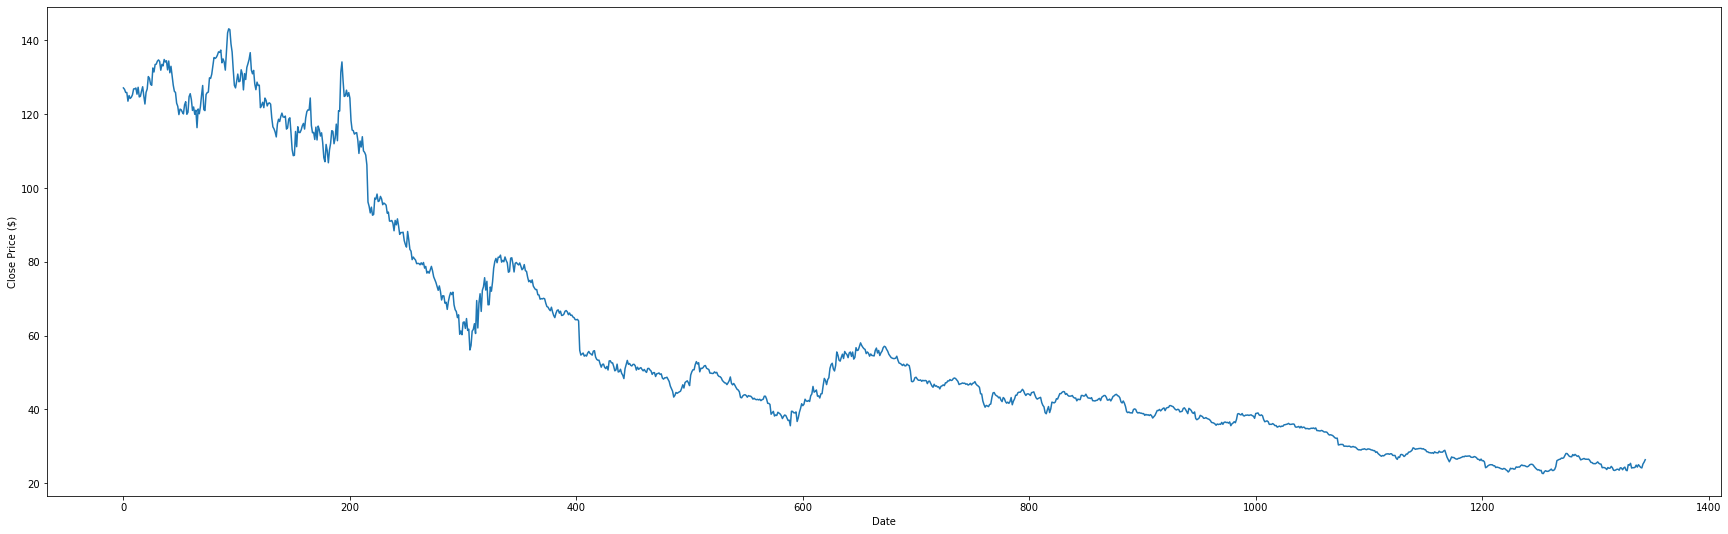

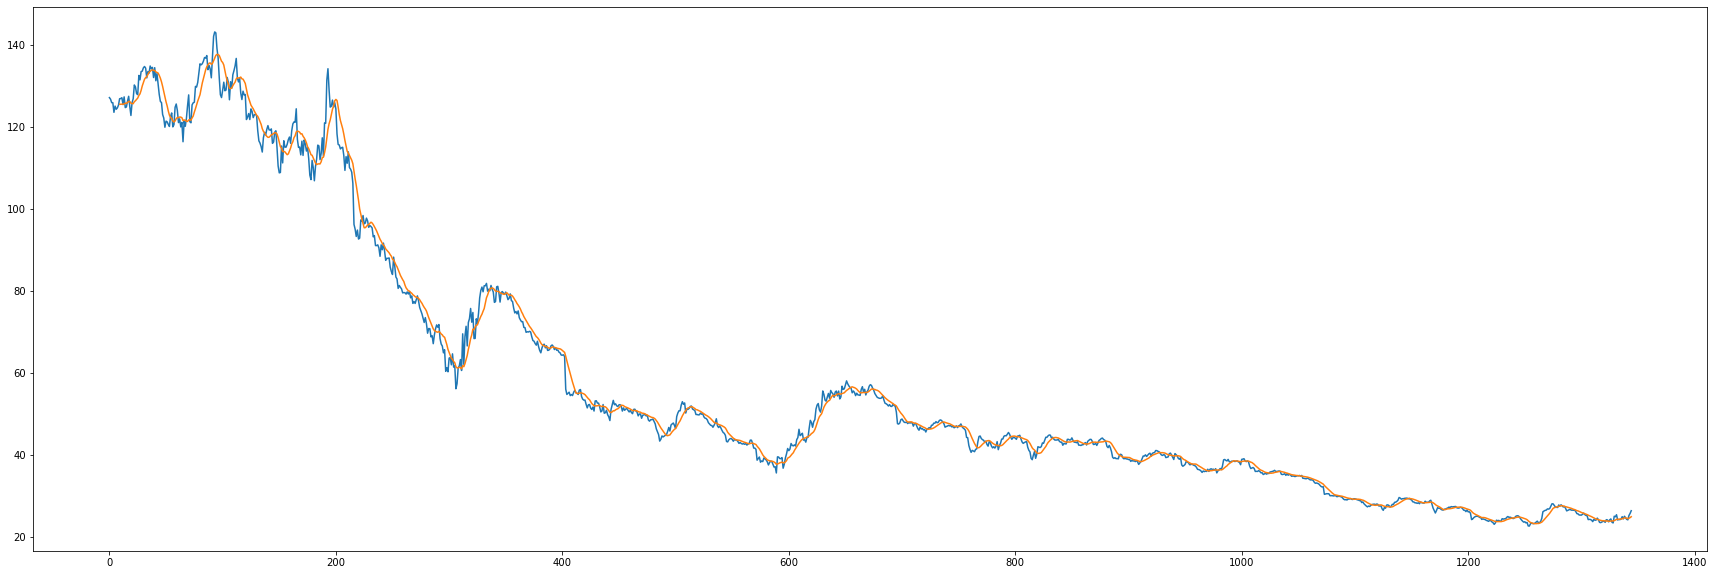

In [26]:
plt.figure(figsize=(30,9))

# plotting close price
stock_data['Close/Last'].plot()
plt.xlabel('Date')
plt.ylabel('Close Price ($)')




stock_data.rolling(7).mean()





plt.figure(figsize=(30,10))
stock_data['Close/Last'].plot()
stock_data.rolling(window=10).mean()['Close/Last'].plot()



plt.show()

In [27]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))
data_to_use


1344

In [28]:
len(stock_data)

1345

In [29]:
# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

In [30]:
#train and test datasets
print(train_end)
print(total_data - train_end)

1075
270


In [31]:
# predicting one step ahead
steps_to_predict = 1

In [32]:
stock_data

,Date,Close/Last,Volume,Open,High,Low,compound,negative,neutral,positive
0,2021-06-09,127.1300,56877940,127.2100,127.7500,126.5200,0.9897,0.035,0.895,0.070
1,2021-06-08,126.7400,74403770,126.6000,128.4600,126.2101,0.9974,0.026,0.872,0.102
2,2021-06-07,125.9000,71057550,126.1700,126.3200,124.8321,0.9981,0.020,0.885,0.095
3,2021-06-04,125.8900,75169340,124.0700,126.1600,123.8500,0.9942,0.024,0.901,0.075
4,2021-06-03,123.5400,76229170,124.6800,124.8500,123.1300,0.9933,0.043,0.869,0.088
...,...,...,...,...,...,...,...,...,...,...
1340,2016-01-08,24.2400,282888000,24.6375,24.7775,24.1900,0.9576,0.071,0.806,0.123
1341,2016-01-07,24.1125,322969840,24.6700,25.0325,24.1075,0.9945,0.042,0.795,0.163
1342,2016-01-06,25.1750,273537080,25.1400,25.5925,24.9675,0.8927,0.044,0.862,0.093
1343,2016-01-05,25.6775,222332560,26.4375,26.4625,25.6025,0.8259,0.065,0.810,0.125


In [33]:
# setting the target variable as the shifted close_price
y = stock_data['Close/Last']
y

0       127.1300
1       126.7400
2       125.9000
3       125.8900
4       123.5400
          ...   
1340     24.2400
1341     24.1125
1342     25.1750
1343     25.6775
1344     26.3375
Name: Close/Last, Length: 1345, dtype: float64

In [34]:
cols = ['Close/Last', 'compound', 'Volume', 'Open', 'High', 'Low']
x = stock_data[cols]
x

,Close/Last,compound,Volume,Open,High,Low
0,127.1300,0.9897,56877940,127.2100,127.7500,126.5200
1,126.7400,0.9974,74403770,126.6000,128.4600,126.2101
2,125.9000,0.9981,71057550,126.1700,126.3200,124.8321
3,125.8900,0.9942,75169340,124.0700,126.1600,123.8500
4,123.5400,0.9933,76229170,124.6800,124.8500,123.1300
...,...,...,...,...,...,...
1340,24.2400,0.9576,282888000,24.6375,24.7775,24.1900
1341,24.1125,0.9945,322969840,24.6700,25.0325,24.1075
1342,25.1750,0.8927,273537080,25.1400,25.5925,24.9675
1343,25.6775,0.8259,222332560,26.4375,26.4625,25.6025


In [35]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

In [36]:
# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

In [37]:
# displaying the scaled feature dataset and the target variable
print(x, y)

[[ 0.7341074   0.98989697 -0.95304015  0.72931462  0.71613907  0.75042541]
 [ 0.7276384   0.99759928 -0.88103412  0.7192403   0.72776198  0.74521712]
 [ 0.71370516  0.99829949 -0.89478229  0.71213873  0.69272954  0.72205794]
 ...
 [-0.95703919  0.89286786 -0.06288169 -0.95639967 -0.95620946 -0.95630344]
 [-0.94870413  0.82604781 -0.27325886 -0.9349711  -0.9419673  -0.94563139]
 [-0.93775658  0.60728218 -0.07627858 -0.94793559 -0.94393992 -0.94735405]] [[ 0.7341074 ]
 [ 0.7276384 ]
 [ 0.71370516]
 ...
 [-0.95703919]
 [-0.94870413]
 [-0.93775658]]


In [38]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

In [39]:
# printing the shape of the train and the test datasets
print( X_train.shape, 'and y:', y_train.shape)
print( X_test.shape, 'and y:', y_test.shape)

(1075, 6) and y: (1075, 1)
(269, 6) and y: (269, 1)


In [40]:
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

In [41]:
print( X_train.shape)
print( X_test.shape)

(1075, 6, 1)
(269, 6, 1)


In [42]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

In [43]:
# setting the model architecture
model=Sequential()
model.add(LSTM(150,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(120,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(120,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [44]:
# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 6, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 120)            130080    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 120)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [45]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

In [46]:
model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=8, verbose=1)

Epoch 1/5
108/108 [==============================] - 9s 30ms/step - loss: 0.0620 - val_loss: 0.0444
Epoch 2/5
108/108 [==============================] - 2s 18ms/step - loss: 0.0295 - val_loss: 0.0190
Epoch 3/5
108/108 [==============================] - 2s 19ms/step - loss: 0.0238 - val_loss: 0.0045
Epoch 4/5
108/108 [==============================] - 2s 18ms/step - loss: 0.0118 - val_loss: 0.0026
Epoch 5/5
108/108 [==============================] - 2s 17ms/step - loss: 0.0042 - val_loss: 0.0051


In [47]:
# performing predictions
predictions = model.predict(X_test) 

In [48]:
model.evaluate(X_test,y_test)

9/9 [==============================] - 0s 10ms/step - loss: 0.0099


0.009890279732644558

In [49]:
# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

In [50]:
# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[35.86088 ],
       [33.676327],
       [35.354237],
       [33.70367 ],
       [35.621777]], dtype=float32)

In [51]:
# Evaluating model


train_loss = model.evaluate(X_train, y_train, batch_size = 1)
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

269/269 [==============================] - 1s 4ms/step - loss: 0.0099


In [52]:
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
# unscaling datasets
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

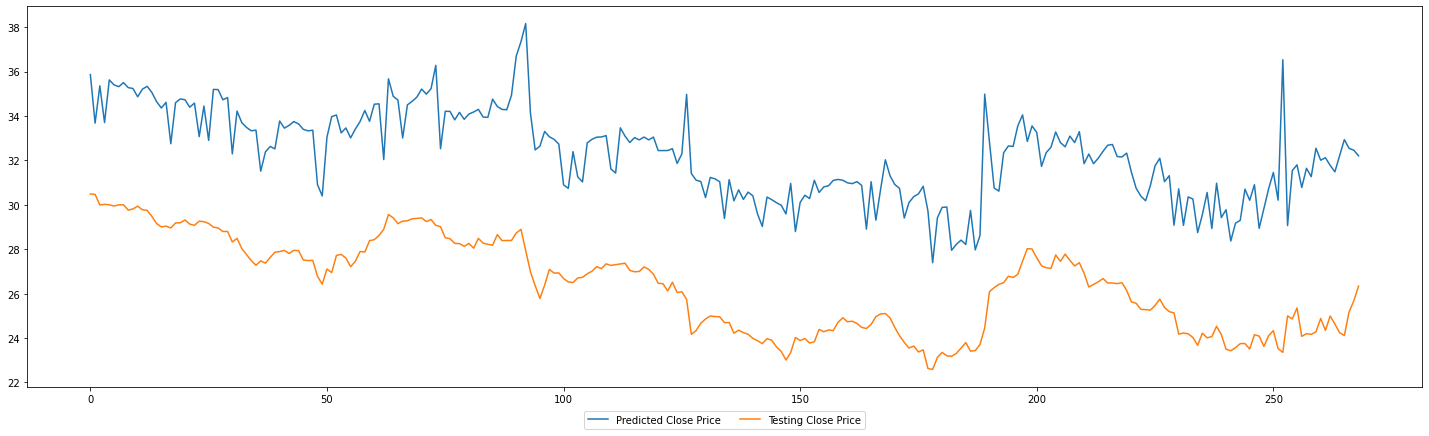

In [53]:
# Performing model on test data


# plotting
plt.figure(figsize=(25,7))

# ploting on label="Training Close Price"
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=2)
plt.show()

In [54]:
model.save('Model.h5')